In [8]:
import torch
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.profiler import profile, ProfilerActivity, record_function
from torch.utils.flop_counter import FlopCounterMode
import psutil
import pandas as pd

### Exercise 1.2

Write PyTorch code for simulating Self-Attention and profiling its “cost". Specifically, measure (1) its computational
complexity with FLOPS, (2) memory usage and (3) wall clock time. Plot each of these trends as a function of input
length varying from 10, 100, 1K, 10K. In your plots make sure to include error bars measured as Standard Error.
Average your results on large enough sentences so that the error bars are reasonably small. Show your results both
on GPU and CPU. Visualize the results appropriately and interpret them. Include a link to your code on Github.

In [9]:


class Attention:
    def __init__(self, d, device):
        self.scale = d ** 0.5
        self.Q = torch.nn.Linear(d, d).to(device)
        self.K = torch.nn.Linear(d, d).to(device)
        self.V = torch.nn.Linear(d, d).to(device)
        
    def forward(self, q, k, v):
        attn_weights = torch.softmax(torch.matmul(q, k.transpose(1, 0)) / self.scale, dim=-1)
        attn_output = torch.matmul(attn_weights, v)
        return attn_output

In [10]:
class Profiler:
    def __init__(self, device):
        self.device = device
        self.flop_counter = FlopCounterMode(display=False)
        self.profiler = torch.profiler.profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],record_shapes=True,profile_memory=True)

        self.start_time = None
        self.start_mem = None

        self.memory = 0
        self.flops = 0
        self.time = 0

    def __enter__(self):
        self.flop_counter.__enter__()
        self.profiler.__enter__()
        self.start_time = time.perf_counter()
        if 'cuda' in self.device:
            torch.cuda.synchronize()
        return self
    
    def __exit__(self, exc_type, exc_value, traceback):
        if 'cuda' in self.device:
            torch.cuda.synchronize()
        self.end_time = time.perf_counter()
        self.profiler.__exit__(exc_type, exc_value, traceback)
        self.flop_counter.__exit__(exc_type, exc_value, traceback)
        max_use = 0
        cur_use = 0
        for e in self.profiler.events():
            #print(f"{e.name} - {e.self_cpu_memory_usage} - {e.self_device_memory_usage}")
            if "cuda" in self.device:
                mem = e.self_device_memory_usage if e.self_device_memory_usage is not None else 0
            else:
                mem = e.self_cpu_memory_usage if e.self_cpu_memory_usage is not None else 0
            cur_use += mem
            max_use = max(max_use, cur_use)
        self.memory = max_use
        self.time = self.end_time - self.start_time
        self.flops = self.flop_counter.get_total_flops()

In [11]:
def get_statistics(attention, seq_len, d, device):
    attention_module = attention(d, device)
    x = torch.randn(seq_len, d).to(device)
    with Profiler(device) as prof:
        with torch.no_grad():
            out = attention_module.forward(x, x, x)
    return prof.flops, prof.time, prof.memory

In [12]:
random_seed = 42
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
iterations = 20
seq_lens = list(torch.logspace(1, 4, base=10, steps=10, dtype=torch.int32).numpy())
print(seq_lens)
d = 512
devices = ['cpu', 'cuda']

res = pd.DataFrame(columns=['device', 'seq_len', 'd', 'flops', 'time', 'memory'])

for device in devices:
    for seq_len in tqdm(seq_lens):
        for _ in range(iterations):
            flops, elapsed_time, memory_usage = get_statistics(Attention, seq_len, d, device)
            res.loc[len(res)] = [device, seq_len, d, flops, elapsed_time, memory_usage]

[np.int32(10), np.int32(21), np.int32(46), np.int32(100), np.int32(215), np.int32(464), np.int32(1000), np.int32(2154), np.int32(4641), np.int32(10000)]


100%|██████████| 10/10 [00:02<00:00,  4.17it/s]


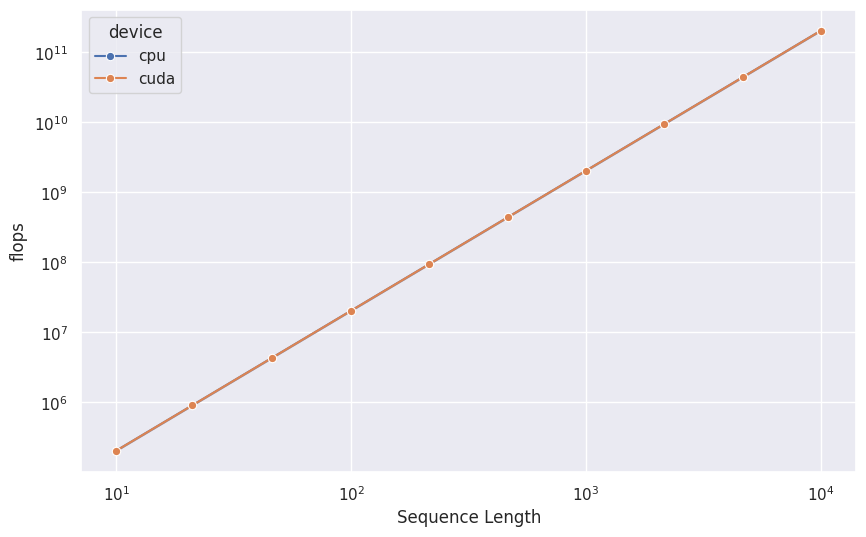

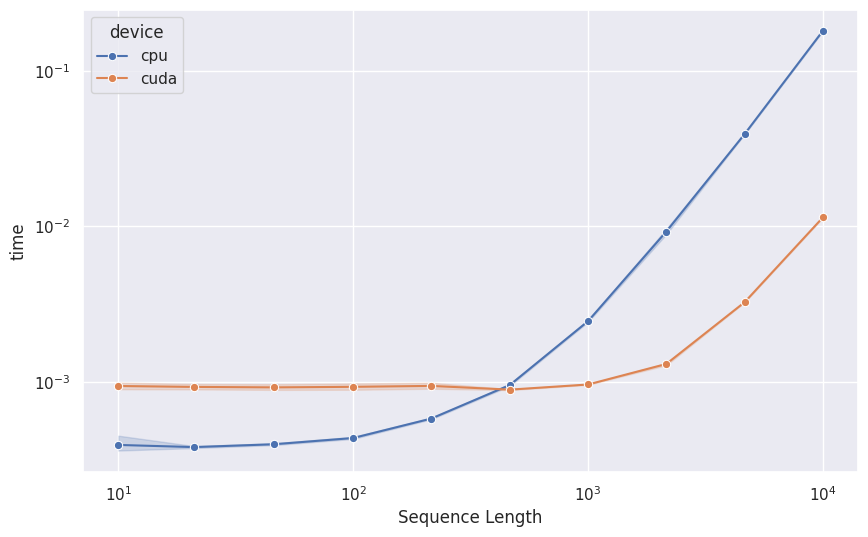

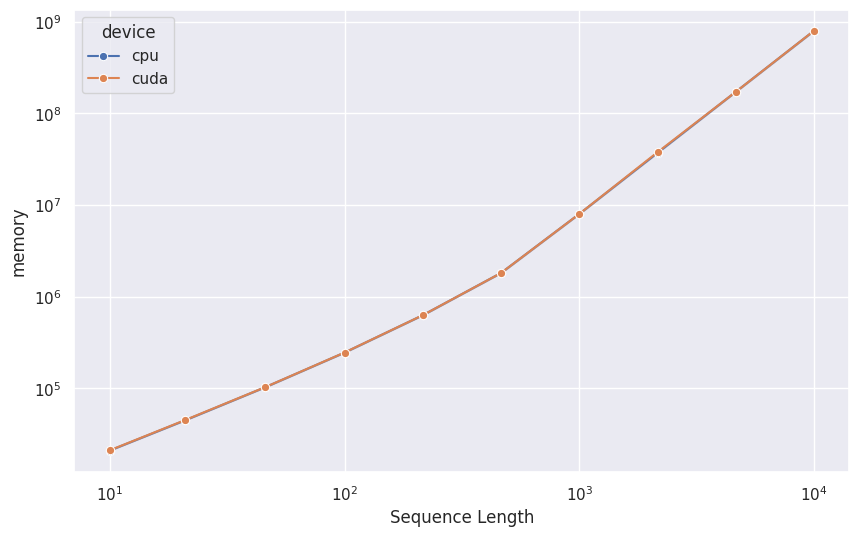

In [13]:
import seaborn as sns
import pandas as pd
sns.set_theme(style="darkgrid")

metrics = ['flops', 'time', 'memory']

for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=res, x='seq_len', y=metric, hue='device', marker='o')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Sequence Length')
    if metric == 'avg_flops':
        plt.ylabel('FLOPs')
        plt.title('FLOPs vs Sequence Length')
    elif metric == 'avg_time':
        plt.ylabel('Time (s)')
        plt.title('Time vs Sequence Length')
    elif metric == 'avg_memory':
        plt.ylabel('Memory (bytes)')
        plt.title('Memory Usage vs Sequence Length')
    plt.grid(True)
    plt.show()